Total parm of Model: 33.235766M

torch.Size([1, 1440, 2])

(252457, 13)

0

torch.Size([15, 1440, 10])
torch.Size([15, 1440, 2])

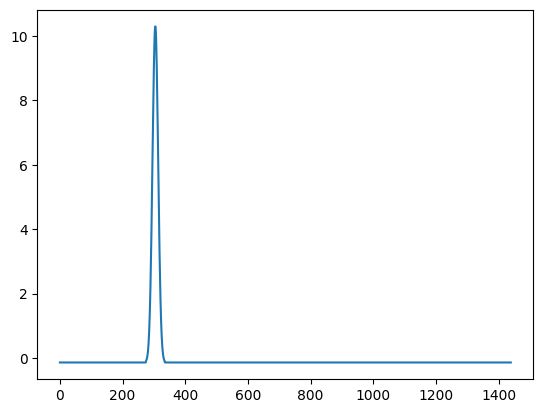

In [1]:
# %%
# %%
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


import torch
import torch.nn as nn
import torch.nn.functional as F

from utils.masking import TriangularCausalMask, ProbMask
from models.encoder import Encoder, EncoderLayer, ConvLayer, EncoderStack
from models.decoder import Decoder, DecoderLayer
from models.attn import FullAttention, ProbAttention, AttentionLayer
from models.embed import DataEmbedding
from models.PatchTST import PatchTST
from rich import print
import joblib


class Informer(nn.Module):
    def __init__(self, enc_in, dec_in, c_out, 
                factor=5, d_model=512, n_heads=8, e_layers=3, d_layers=2, d_ff=512, 
                dropout=0.0, attn='prob', embed='fixed', freq='h', activation='gelu', 
                output_attention = False, distil=True, mix=True,
                device=torch.device('cuda:0')):
        super(Informer, self).__init__()
        # self.pred_len = out_len
        self.attn = attn
        self.output_attention = output_attention

        # Encoding
        self.enc_embedding = DataEmbedding(enc_in, d_model, embed, freq, dropout, max_len=ts_length)
        self.dec_embedding = DataEmbedding(dec_in, d_model, embed, freq, dropout, max_len=ts_length)
        # Attention
        Attn = ProbAttention if attn=='prob' else FullAttention
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(Attn(False, factor, attention_dropout=dropout, output_attention=output_attention), 
                                d_model, n_heads, mix=False),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation
                ) for l in range(e_layers)
            ],
            [
                ConvLayer(
                    d_model
                ) for l in range(e_layers-1)
            ] if distil else None,
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(Attn(True, factor, attention_dropout=dropout, output_attention=False), 
                                d_model, n_heads, mix=mix),
                    AttentionLayer(FullAttention(False, factor, attention_dropout=dropout, output_attention=False), 
                                d_model, n_heads, mix=False),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation,
                )
                for l in range(d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        self.projection = nn.Linear(d_model, c_out, bias=True)
        # self.finalact = nn.Softmax(dim=-1)

    def forward(self, x_enc, x_dec, 
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        enc_out = self.enc_embedding(x_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)

        dec_out = self.dec_embedding(x_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask)
        dec_out = self.projection(dec_out)
        # dec_out = self.finalact(dec_out)
        if self.output_attention:
            return dec_out, attns  # 返回整个dec_out和注意力权重（如果需要）
        else:
            return dec_out  # 返回整个dec_out

args = dotdict()
args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints
args.factor = 5 # probsparse attn factor
args.e_layers = 4 # num of encoder layers
args.d_layers = 4 # num of decoder layers
args.dropout = 0.01 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'learned' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = -1
args.freq = 'h'

ts_length = 1440
max_batch = 64

enc_in = 10
dec_in = enc_in
c_out = 2
n_heads = 8
d_model = 256
d_ff = 256
# model = Informer(
#     enc_in,
#     dec_in, 
#     c_out, 
#     args.factor,
#     d_model, 
#     n_heads, 
#     args.e_layers,
#     args.d_layers, 
#     d_ff,
#     args.dropout, 
#     args.attn,
#     args.embed,
#     args.freq,
#     args.activation,
#     args.output_attention,
#     args.distil,
#     args.mix,
#     'cuda'
# ).float()




# args.enc_in = 10
args.seq_len = 1440
args.pred_len = 1440

args.e_layers = 4
args.n_heads = 8
args.d_model = 128
args.d_ff = 128
args.dropout = 0.05
args.fc_dropout = 0.05
args.head_dropout = 0.0

args.individual = 0

args.patch_len = 32
args.stride = 8
args.padding_patch = 'end'

args.revin = 1
args.affine = 0
args.subtract_last = 0

args.decomposition = 0
args.kernel_size = 64

class customPatchTST(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.model = PatchTST(args).float()
        self.fc = nn.Linear(enc_in, c_out)    
    
    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x
    

model = customPatchTST(args).float()



model_name = f'{d_model}d_modelx{d_ff}d_ffx{n_heads}heads_{args.e_layers}enc_layers_{args.d_layers}dec_layers'
print(f"Total parm of Model: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6}M")
# torch.Size([1, 96, 7]) torch.Size([1, 96, 4]) torch.Size([1, 72, 7]) torch.Size([1, 72, 4])
# print(batch_x.shape, batch_x_mark.shape, dec_inp.shape, batch_y_mark.shape)

print(model(torch.rand(1, ts_length, enc_in)).shape)


from pathlib import Path
import pickle
import numpy as np
from matplotlib import pyplot as plt



with open('/home/ljb/all_data_new.pkl', 'rb') as f:
    arr = pickle.load(f)
    print(arr[0].shape)

downsample_arr = []
downsample_rate = int(17280 / ts_length)
for ts in arr:
    # if downsample_rate != 1:
    #     downsample_arr.append(ts[::downsample_rate])
    # else:
    #     downsample_arr.append(ts)
    downsample_arr.append(ts)

class TimeSeries:
    def __init__(self, raw) -> None:
        raw = torch.from_numpy(raw).float()
        self.x = raw[:, :-1]
        self.y = F.one_hot(raw[:, -1:].long(), 2)[:,0].float()
        pass
    
    

all_arr = []
skip = 0
for i in downsample_arr:
    if len(i) < 1900:
        print(i.shape)
        skip += 1
        continue
    all_arr.append(TimeSeries(i))
print(skip)

import random

train_arr = random.sample(all_arr, int(len(all_arr) * 0.8))
val_arr = list(set(all_arr) - set(train_arr))
SAMPLE_FREQ = downsample_rate # 1 obs per minute

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.len = x.shape[0]
        self.length = x.shape[1]
        self.num_feat = x.shape[2]
        

    def aug(self,x,y):
        if torch.rand(1) < 0.5:
            x = torch.flip(x, dims=[0])
            y = torch.flip(y, dims=[0])
        if torch.rand(1) < 0.2:
            return x, y
        clip_length = int((torch.rand(1) * (1.0 - 0.2) + 0.2) * self.length)
        pad_length = self.length - clip_length
        # print(pad_length, clip_length)
        x = x[:clip_length]
        y = y[:clip_length]
        
        x = torch.cat([x, -torch.ones(pad_length, self.num_feat)], dim=0)
        y = torch.cat([y, torch.cat([torch.zeros(pad_length, 1), torch.ones(pad_length, 1)], dim=1)], dim=0)
        return x, y
        
    def __getitem__(self, index):
        return self.aug(self.x[index], self.y[index])
    
    def __len__(self):
        return self.len

SIGMA = 720 #average length of day is 24*60*12 = 17280 for comparison
from math import sqrt, pi, exp
import gc

def normalize(y):
    mean = y[:,0].mean().item()
    std = y[:,0].std().item()
    y[:,0] = (y[:,0]-mean)/(std+1e-16)
    mean = y[:,1].mean().item()
    std = y[:,1].std().item()
    y[:,1] = (y[:,1]-mean)/(std+1e-16)
    return y

# %%

import numpy as np 
def random_split_tensor(tensor, random_new_length, max_length=2880, min_length=None):
    """
    Fixed version of the function to split a 2D tensor along the first dimension into sub-tensors of lengths 
    not exceeding max_length and not less than min_length. Averages the lengths of the last two sub-tensors if possible.
    
    Parameters:
    - tensor (torch.Tensor): The input tensor of shape (length, 12).
    - max_length (int): The maximum length for each sub-tensor.
    - min_length (int): The minimum length for each sub-tensor.
    
    Returns:
    - List[torch.Tensor]: A list of sub-tensors.
    """
    min_length = int(max_length / 1.2) if min_length is None else min_length
    try:
        # Get the total length of the tensor
        length = tensor.shape[0]
        if length <= max_length:
            return []
        batch_size = length // random_new_length
        # print(length - batch_size * random_new_length)
        tensor = tensor[:batch_size * random_new_length]
        batch_tensor = tensor.reshape(batch_size, random_new_length, -1)
    except Exception as e:
        print(tensor.shape)
        raise e
    return batch_tensor


class SleepDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        file
    ):
        self.targets,self.data,self.ids = joblib.load(file)
            
    def downsample_seq_generate_features(self,feat, downsample_factor = SAMPLE_FREQ):
        # downsample data and generate features
        if len(feat)%SAMPLE_FREQ==0:
            feat = np.concatenate([feat,np.zeros(SAMPLE_FREQ-((len(feat))%SAMPLE_FREQ))+feat[-1]])
        feat = np.reshape(feat, (-1,SAMPLE_FREQ))
        feat_mean = np.mean(feat,1)
        feat_std = np.std(feat,1)
        feat_median = np.median(feat,1)
        feat_max = np.max(feat,1)
        feat_min = np.min(feat,1)

        return np.dstack([feat_mean,feat_std,feat_median,feat_max,feat_min])[0]
    def downsample_seq(self,feat, downsample_factor = SAMPLE_FREQ):
        # downsample data
        if len(feat)%SAMPLE_FREQ==0:
            feat = np.concatenate([feat,np.zeros(SAMPLE_FREQ-((len(feat))%SAMPLE_FREQ))+feat[-1]])
        feat = np.reshape(feat, (-1,SAMPLE_FREQ))
        feat_mean = np.mean(feat,1)
        return feat_mean
    
    def gauss(self,n=SIGMA,sigma=SIGMA*0.15):
        # guassian distribution function
        r = range(-int(n/2),int(n/2)+1)
        return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in r]

    def aug(self,temp_x, temp_y):
        
        if torch.rand(1) < 0.2:
            temp_x = torch.flip(temp_x, dims=[0])
            temp_y = torch.flip(temp_y, dims=[0])
        
        if temp_x.shape[0] % 2 != 0:
            temp_x = temp_x[:-1]
            temp_y = temp_y[:-1]

        if temp_x.shape[0] >= ts_length * 10:
            if torch.rand(1) < 0.5:
                start_index = int(torch.rand(1) * (len(temp_y)-ts_length))
                temp_x = temp_x[start_index:]
                temp_y = temp_y[start_index:]
            # temp_x = temp_x[:ts_length * 10]
            # temp_y = temp_y[:ts_length * 10]
            # new_length = temp_x.shape[0]
            # temp_x = temp_x.reshape(-1, ts_length, temp_x.shape[-1])
        else:
            if torch.rand(1) < 0.2:
                start_index = int(torch.rand(1) * (len(temp_y)-ts_length))
                temp_x = temp_x[start_index:]
                temp_y = temp_y[start_index:]
        min_length = int(ts_length / 1.2)
        # max_length = ts_length
        # random_new_length = np.random.randint(min_length, max_length)
        random_new_length = ts_length
        temp_x = random_split_tensor(temp_x, random_new_length, ts_length, min_length)
        temp_y = random_split_tensor(temp_y, random_new_length, ts_length, min_length)
        
        if temp_x.shape[0] > max_batch:
            # random select max_batch batch
            indices = torch.randperm(temp_x.size(0))[:max_batch]
            temp_x = torch.index_select(temp_x, 0, indices)
            temp_y = torch.index_select(temp_y, 0, indices)

                
        # temp_x = temp_x.unsqueeze(0)
        # temp_y = temp_y.unsqueeze(0)
            
        return temp_x, temp_y
    
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        X = self.data[index][['anglez','enmo']]
        y = self.targets[index]
        
        # turn target inds into array
        target_guassian = np.zeros((len(X),2))
        for s,e in y:
            st1,st2 = max(0,s-SIGMA//2),s+SIGMA//2+1
            ed1,ed2 = e-SIGMA//2,min(len(X),e+SIGMA//2+1)
            target_guassian[st1:st2,0] = self.gauss()[st1-(s-SIGMA//2):]
            target_guassian[ed1:ed2,1] = self.gauss()[:SIGMA+1-((e+SIGMA//2+1)-ed2)]
            gc.collect()
        y = target_guassian
        gc.collect()
        X = np.concatenate([self.downsample_seq_generate_features(X.values[:,i],SAMPLE_FREQ) for i in range(X.shape[1])],-1)
        gc.collect()
        y = np.dstack([self.downsample_seq(y[:,i],SAMPLE_FREQ) for i in range(y.shape[1])])[0]
        gc.collect()
        y = normalize(torch.from_numpy(y))
        X = torch.from_numpy(X)
        return self.aug(X, y)

class newMyDataset(torch.utils.data.Dataset):
    def __init__(self, train_arr):
        self.train_arr = train_arr
        self.len = len(train_arr)
        # self.featss = train_arr[0].x.shape[-1]

    def gauss(self,n=SIGMA,sigma=SIGMA*0.15):
        # guassian distribution function
        r = range(-int(n/2),int(n/2)+1)
        return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in r]

    def aug(self,ts):
        temp_x = ts.x
        temp_y = ts.y
        
        if torch.rand(1) < 0.2:
            temp_x = torch.flip(temp_x, dims=[0])
            temp_y = torch.flip(temp_y, dims=[0])
        
        if temp_x.shape[0] % 2 != 0:
            temp_x = temp_x[:-1]
            temp_y = temp_y[:-1]

        if temp_x.shape[0] >= ts_length * 10:
            if torch.rand(1) < 0.5:
                start_index = int(torch.rand(1) * (len(temp_y)-ts_length))
                temp_x = temp_x[start_index:]
                temp_y = temp_y[start_index:]
            temp_x = temp_x[:ts_length * 10]
            temp_y = temp_y[:ts_length * 10]
        else:
            if torch.rand(1) < 0.2:
                start_index = int(torch.rand(1) * (len(temp_y)-ts_length))
                temp_x = temp_x[start_index:]
                temp_y = temp_y[start_index:]
        temp_x = temp_x.unsqueeze(0)
        temp_y = temp_y.unsqueeze(0)
            
        return temp_x, temp_y
        
    def __getitem__(self, index):
        return self.aug(self.train_arr[index])
    
    def __len__(self):
        return self.len

# print(x_val.shape)
# print(y_val.shape)
ds = SleepDataset("/home/ljb/train_data.pkl")
# ds = SleepDataset(train_arr)
dl = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=True, num_workers=24)
# ds_val = newMyDataset(val_arr)
# dl_val = torch.utils.data.DataLoader(ds_val, batch_size=1, shuffle=True, num_workers=24)
for x,y in ds:
    print(x.shape, y.shape)
    plt.plot(y[0,:3000,0].numpy())
    break

# %%
def draw_one_batch(x, y, y_pred, title=None):
    x, y, y_pred = x.detach().cpu().numpy(), y.detach().cpu().numpy(), y_pred.detach().cpu().numpy()
    # y_pred = F.softmax(torch.from_numpy(y_pred), dim=-1).numpy()
    x = x[0,:,1]
    y = y[0,:,1]
    y_pred = y_pred[0,:,1]
    if title is not None:
        plt.title(title)
    plt.plot(x, label='x')
    plt.plot(y, label='y')
    plt.plot(y_pred, label='y_pred')
    plt.legend()
    plt.show()
    
# test_batch = ds[0]
# draw_one_batch(test_batch, test_batch, test_batch)

# model.load_state_dict(torch.load('256d_modelx256d_ffx8heads_3enc_layers_4dec_layers/model_20.pth'))

def split_tensor(tensor, max_length=ts_length, min_length=None):
    """
    Fixed version of the function to split a 2D tensor along the first dimension into sub-tensors of lengths 
    not exceeding max_length and not less than min_length. Averages the lengths of the last two sub-tensors if possible.
    
    Parameters:
    - tensor (torch.Tensor): The input tensor of shape (length, 12).
    - max_length (int): The maximum length for each sub-tensor.
    - min_length (int): The minimum length for each sub-tensor.
    
    Returns:
    - List[torch.Tensor]: A list of sub-tensors.
    """
    min_length = int(max_length / 2) if min_length is None else min_length
    try:
        # Get the total length of the tensor
        length = tensor.shape[0]
        if length <= max_length:
            return []
        # Initialize the list to hold sub-tensor lengths
        sub_lengths = []
        
        while length > 0:
            if length >= max_length:
                sub_lengths.append(max_length)
                length -= max_length
            elif length >= min_length:
                sub_lengths.append(length)
                length = 0  # all the tensor length has been allocated
            else:
                # If the remaining length is less than the min_length, borrow some length from the last added sub-tensor
                # (which has max_length) to make it at least min_length
                last_length = sub_lengths.pop()
                sub_lengths.append(min_length)
                remaining_last_length = last_length - (min_length - length)
                if remaining_last_length >= min_length:
                    sub_lengths.append(remaining_last_length)
                length = 0  # all the tensor length has been allocated
        
        # Average the last two sub-tensors if their total length is greater than 2 * min_length
        if len(sub_lengths) > 1 and sum(sub_lengths[-2:]) > 2 * min_length:
            last_two_sum = sub_lengths.pop() + sub_lengths.pop()
            avg_length1 = last_two_sum // 2
            avg_length2 = last_two_sum - avg_length1  # Ensure the two lengths sum up to the original sum
            sub_lengths.extend([avg_length1, avg_length2])
        
        # Split the tensor
        sub_tensors = torch.split(tensor, sub_lengths, dim=0)
    except Exception as e:
        print(tensor.shape)
        raise e
    ret = []
    shape_dict = {}
    for sub in sub_tensors:
        length = sub.shape[0]
        if length in shape_dict.keys():
            shape_dict[length].append(sub.unsqueeze(0))
        else:
            shape_dict[length] = [sub.unsqueeze(0)]
    for k, v in shape_dict.items():
        ret.append(torch.cat(v, dim=0))
    return ret


# for i, _ in zip(split_tensor(torch.rand(16541, 2)), split_tensor(torch.rand(16541, 2))):
#     print(i.shape)

Path(model_name).mkdir(exist_ok=True)

from tqdm import tqdm

val_pre_epoch = 10

def train_one_epoch(dl, model, loss_fn, optimizer, e, scheduler=None):
    model.train()
    model = model.cuda()
    train_loss = []
    # y_pred = None
    for i, (x, y) in enumerate(dl):
        if len(x.shape) == 4:
            x = x[0]
            y = y[0]
        try:
            x = x.float().cuda()
            y = y.float().cuda()
            optimizer.zero_grad()
            
            y_pred = model(x)
                
            loss = loss_fn(y_pred, y)
            loss.backward()
            train_loss.append(loss.item())
            # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1e-1)
            optimizer.step()
            torch.cuda.empty_cache()
        except Exception as e:
            print(x.shape, y.shape)
            raise e
        
    if scheduler is not None:
        scheduler.step()

    train_loss = np.average(train_loss)
    print(">"*20+f"Epoch {e} Train Loss: "+str(train_loss)+">"*20)
    if e % val_pre_epoch == 0:
        torch.save(model.state_dict(), f'./{model_name}/model_{e}.pth')
        draw_one_batch(x, y, y_pred, title=f"Train")

epoch = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = None
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch, eta_min=1e-4)
loss_fn = torch.nn.MSELoss()

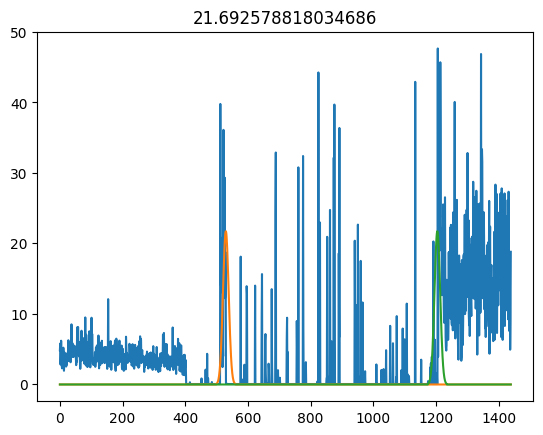

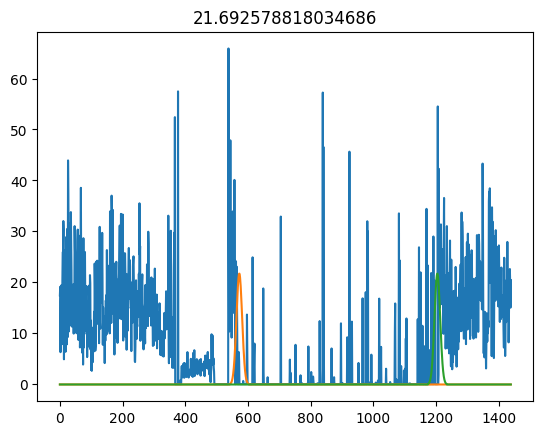

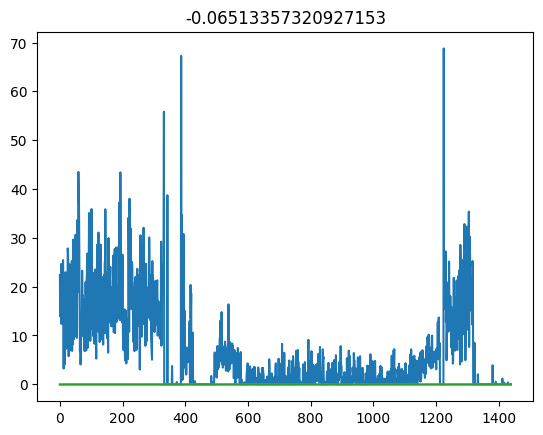

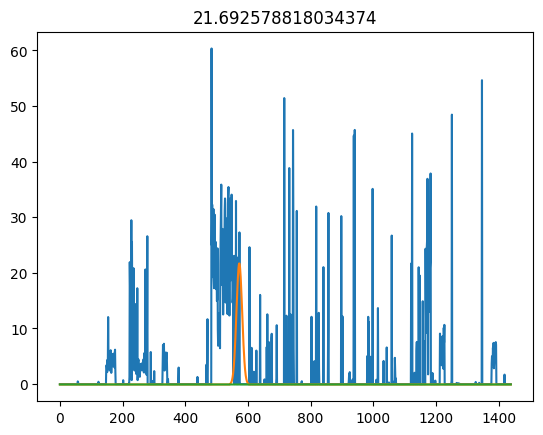

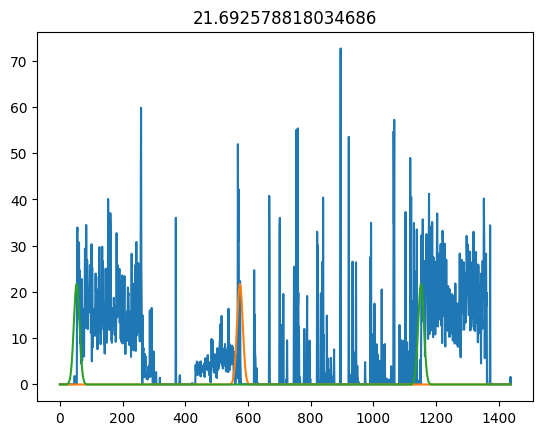

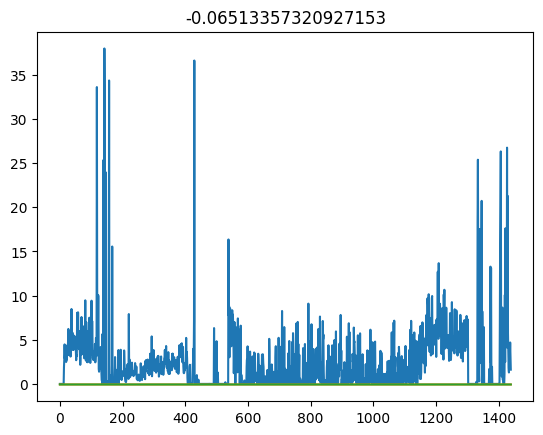

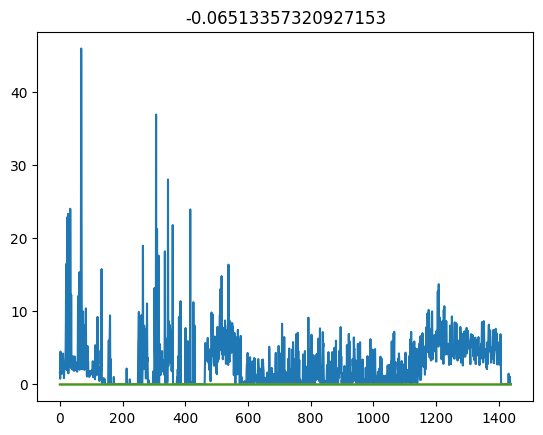

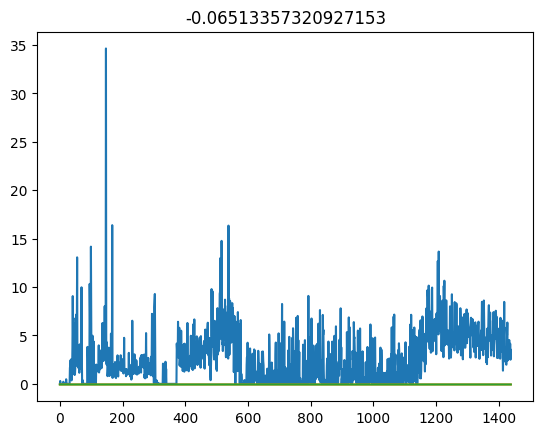

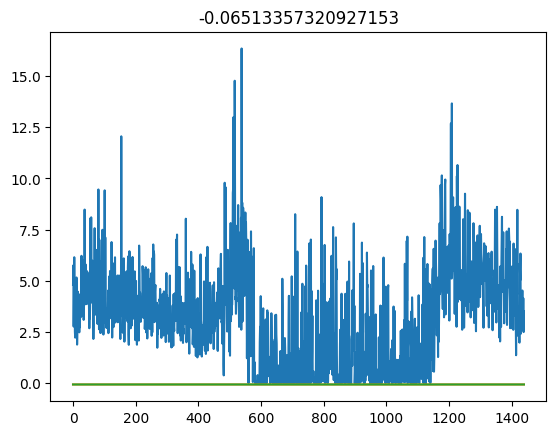

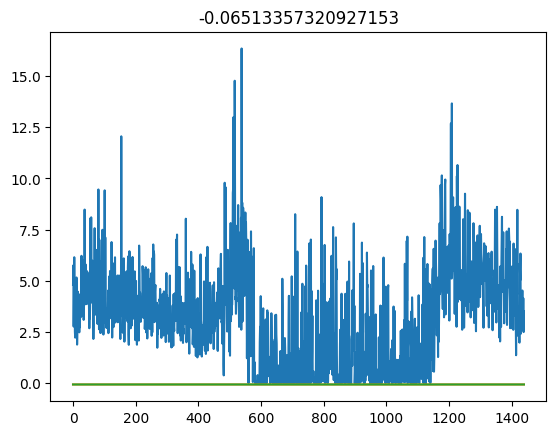

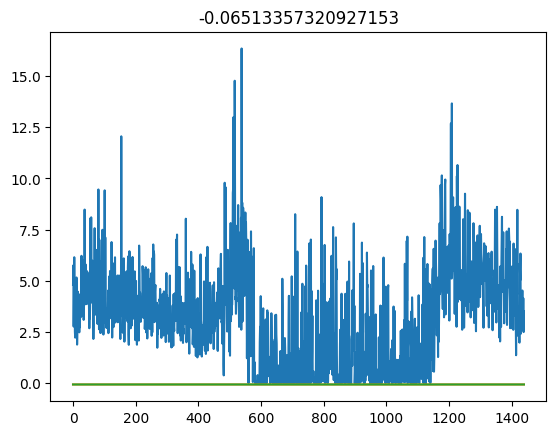

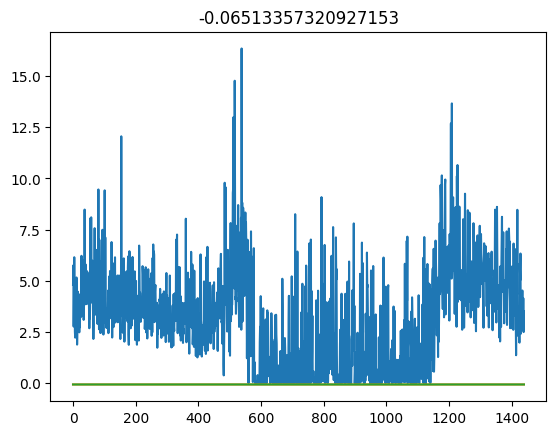

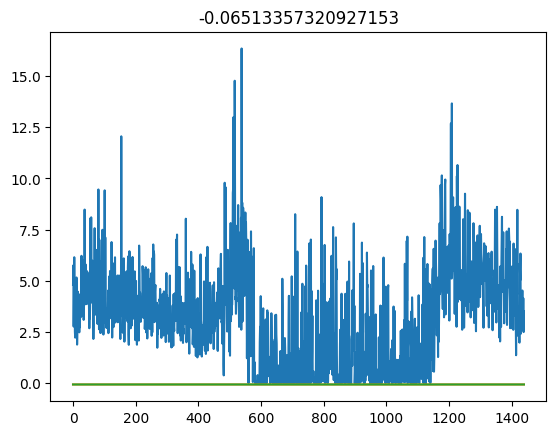

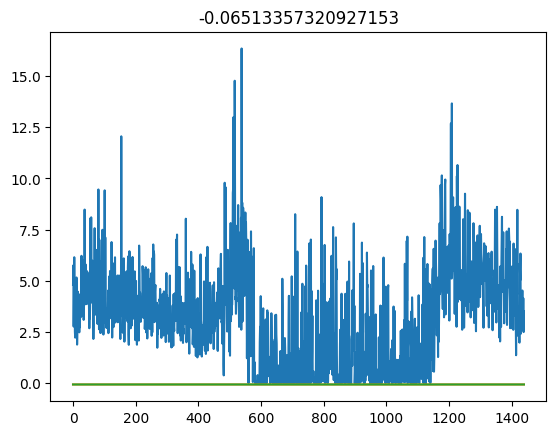

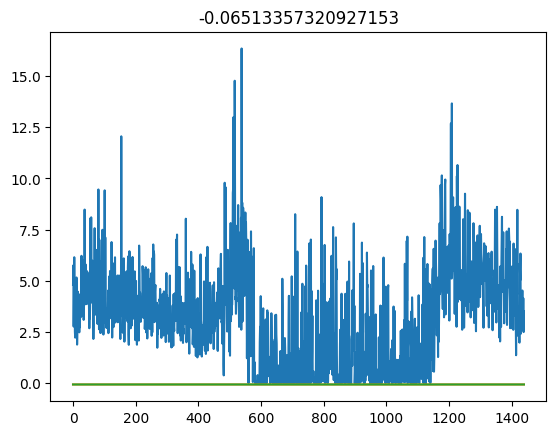

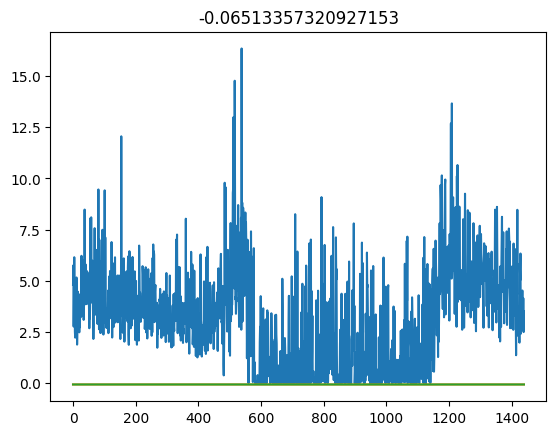

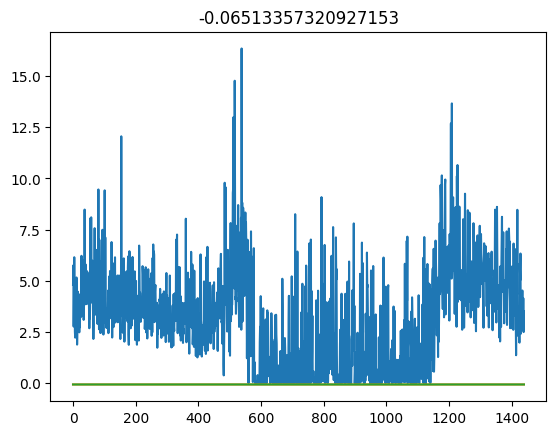

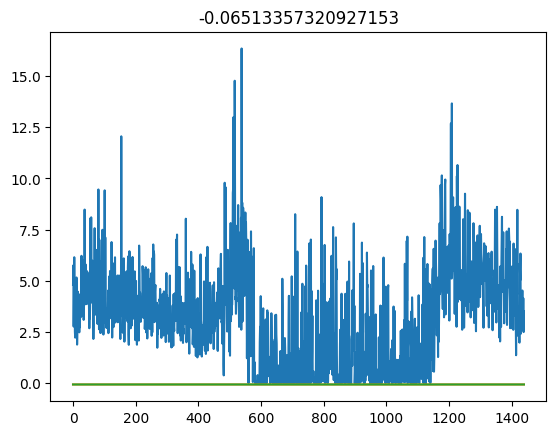

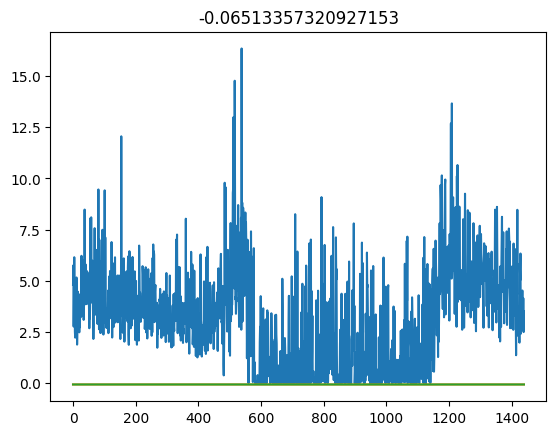

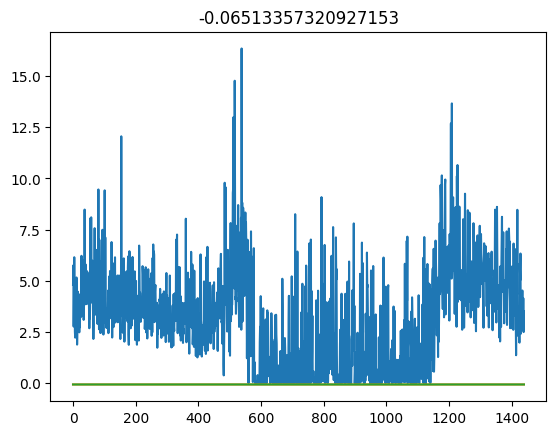

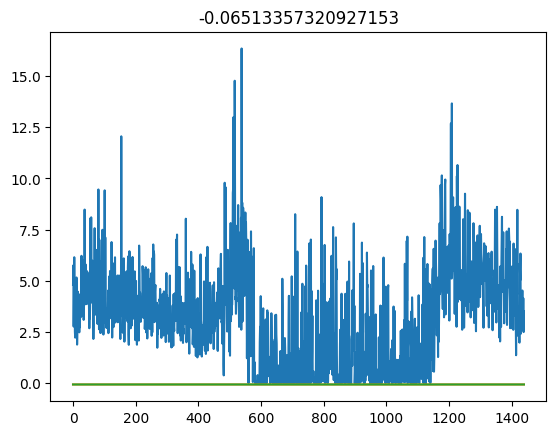

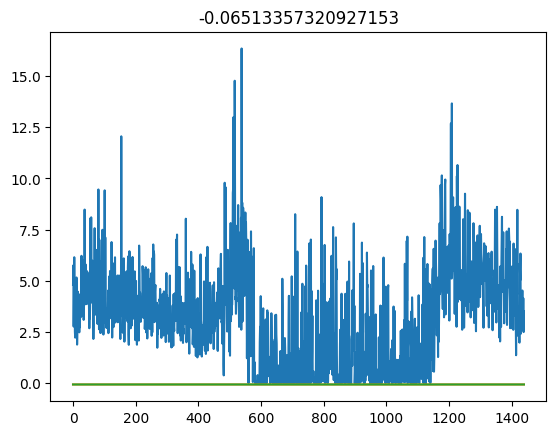

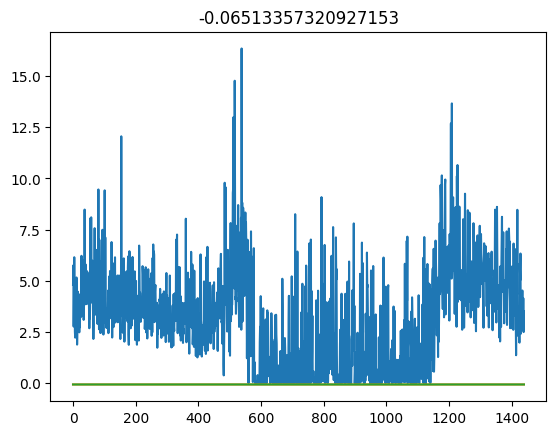

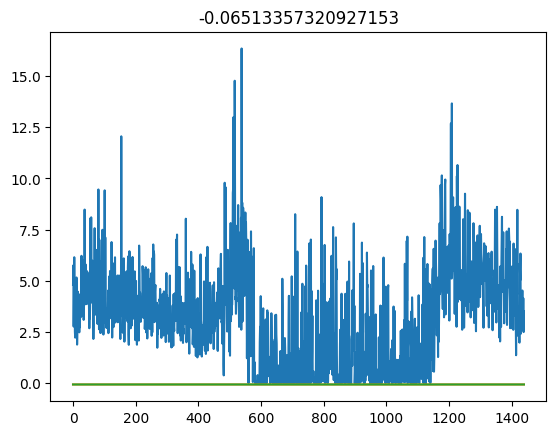

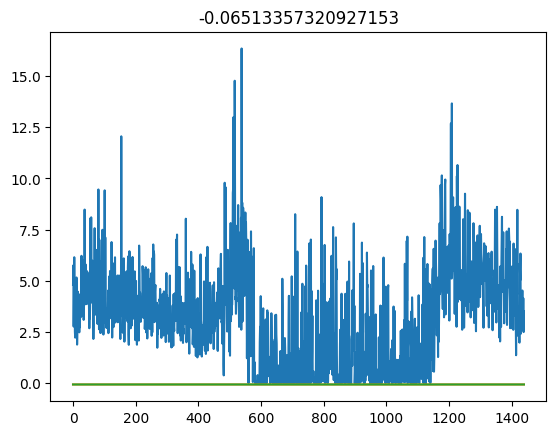

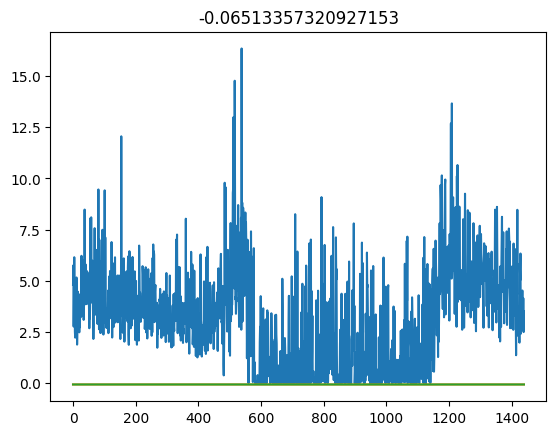

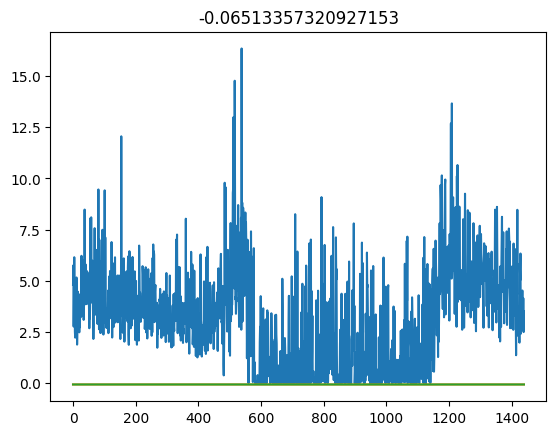

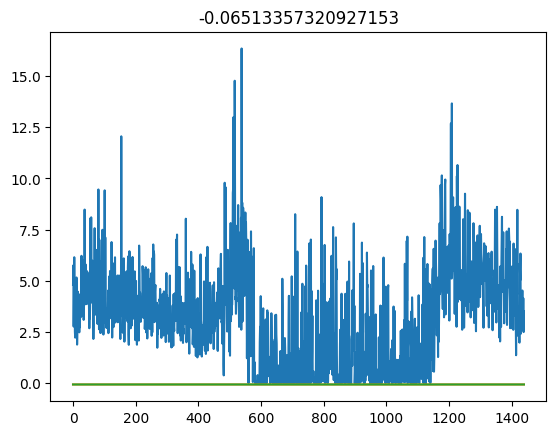

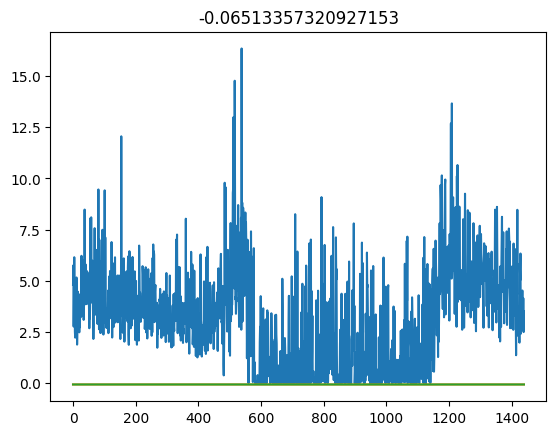

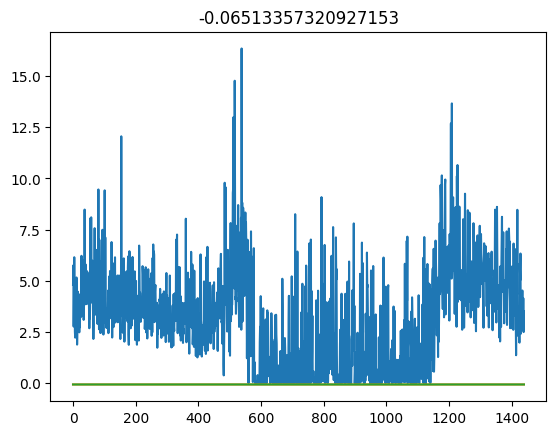

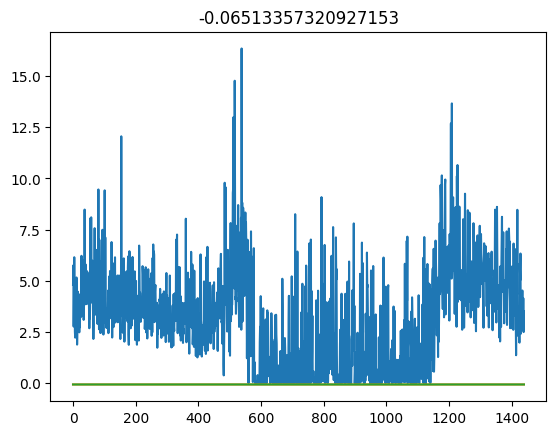

In [13]:
x, y = ds[1]
for tx, ty, in zip(x, y):
    plt.title(f"{ty.max()}")
    plt.plot(tx[:, 1])
    plt.plot(ty)
    plt.show()
    # break
    # pred_y = model(tx.unsqueeze(0).float()).detach().cpu().numpy()
    # plt.plot(pred_y[0,:])
    # break



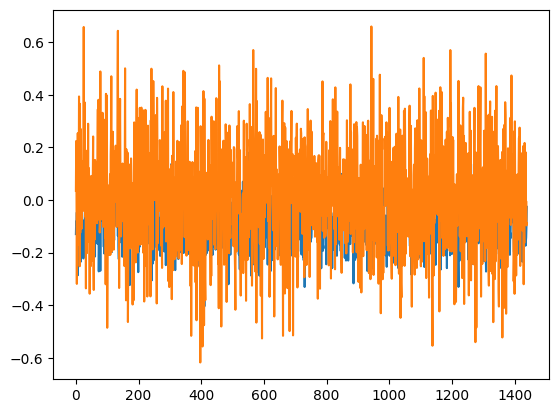

In [22]:
plt.plot(pred_y[0,:])

In [14]:
loss_fn(torch.rand_like(ty), ty)

tensor(1.4977, dtype=torch.float64)

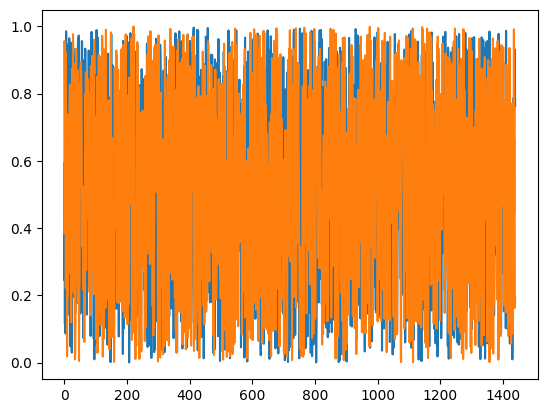

In [15]:
plt.plot(torch.rand_like(ty))